In [3]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold

For the comparison to be meaningful we need to separate the dataset in train and test, which will be unchanged during the whole process.

Number of patients: 131
Number of lesions: 555


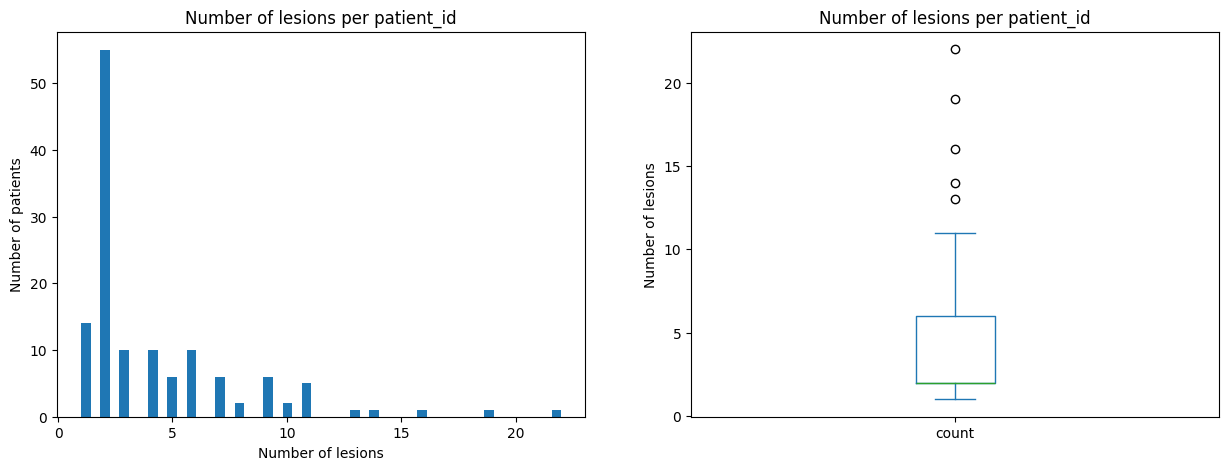

In [5]:
bbox_dataframe = pd.read_csv(repo_path / 'data/CDD-CESM/metadata/bboxes/bbox_CESM_corrected.csv')
print('Number of patients:', bbox_dataframe['patient_id'].nunique())
print('Number of lesions:', bbox_dataframe.shape[0])


# plot the number of lesions per patient_id, in form of histogram and boxplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
bbox_dataframe['patient_id'].value_counts().plot(kind='hist', bins=50, ax=axs[0])
axs[0].set_title('Number of lesions per patient_id')
axs[0].set_xlabel('Number of lesions')
axs[0].set_ylabel('Number of patients')
bbox_dataframe['patient_id'].value_counts().plot(kind='box', ax=axs[1])
axs[1].set_title('Number of lesions per patient_id')
axs[1].set_ylabel('Number of lesions')
plt.show()


We see must of the patients only have two lesions lesions, and the must of the aptient have less than 11 lesions.<br>
The split we will perform will be startified by the number of lesions, so we can have a good representation of the data in both train and test.<br>

    The split will be 75% train and 25% test.

In [6]:
# add an extra column to the dataset, containing the number of lesions per patient_id
bbox_dataframe['lesions_per_patient'] = bbox_dataframe['patient_id'].map(bbox_dataframe['patient_id'].value_counts())
bbox_dataframe

,patient_id,image_name,region_id,bbox,lesions_per_patient
0,2,P2_R_CM_CC,0,"(536, 2083, 355, 307)",19
1,2,P2_R_CM_CC,1,"(633, 1620, 411, 283)",19
2,2,P2_R_CM_CC,2,"(347, 1233, 307, 211)",19
3,2,P2_R_CM_CC,3,"(629, 750, 129, 129)",19
4,2,P2_R_CM_CC,4,"(738, 1161, 153, 153)",19
...,...,...,...,...,...
550,323,P323_L_CM_MLO,1,"(72, 1893, 864, 569)",6
551,325,P325_R_CM_CC,0,"(400, 593, 91, 103)",4
552,325,P325_R_CM_CC,1,"(570, 1351, 129, 107)",4
553,325,P325_R_CM_MLO,0,"(535, 916, 97, 103)",4


In [32]:
# saving paths
save_meta_dir = repo_path / 'data/CDD-CESM/metadata/bboxes/split_1'
save_meta_dir.mkdir(parents=True, exist_ok=True)

# perform startified group k-fold split, the group is the patient_id and the stratification is the number of lesions per patient_id, we want 75% of the data to be in the training set
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)
for train_index, test_index in sgkf.split(bbox_dataframe, bbox_dataframe['lesions_per_patient'], groups=bbox_dataframe['patient_id']):
    c_train_set = bbox_dataframe.iloc[train_index].reset_index(drop=True, inplace=False)
    test_set = bbox_dataframe.iloc[test_index].reset_index(drop=True, inplace=False)
    # split train also into train and validation, 80% train, 20% validation
    train_val = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    for new_train_index, val_index in train_val.split(c_train_set, c_train_set['lesions_per_patient'], groups=c_train_set['patient_id']):
        train_set = c_train_set.iloc[new_train_index]
        val_set = c_train_set.iloc[val_index]
        # check if the validation set has at least 10% of the total number of patients
        if val_set['patient_id'].nunique() > 0.1 * bbox_dataframe['patient_id'].nunique():
            break

Training set:
Number of patients: 79
Number of lesions: 322
Validation set:
Number of patients: 19
Number of lesions: 75
Test set:
Number of patients: 33
Number of lesions: 158


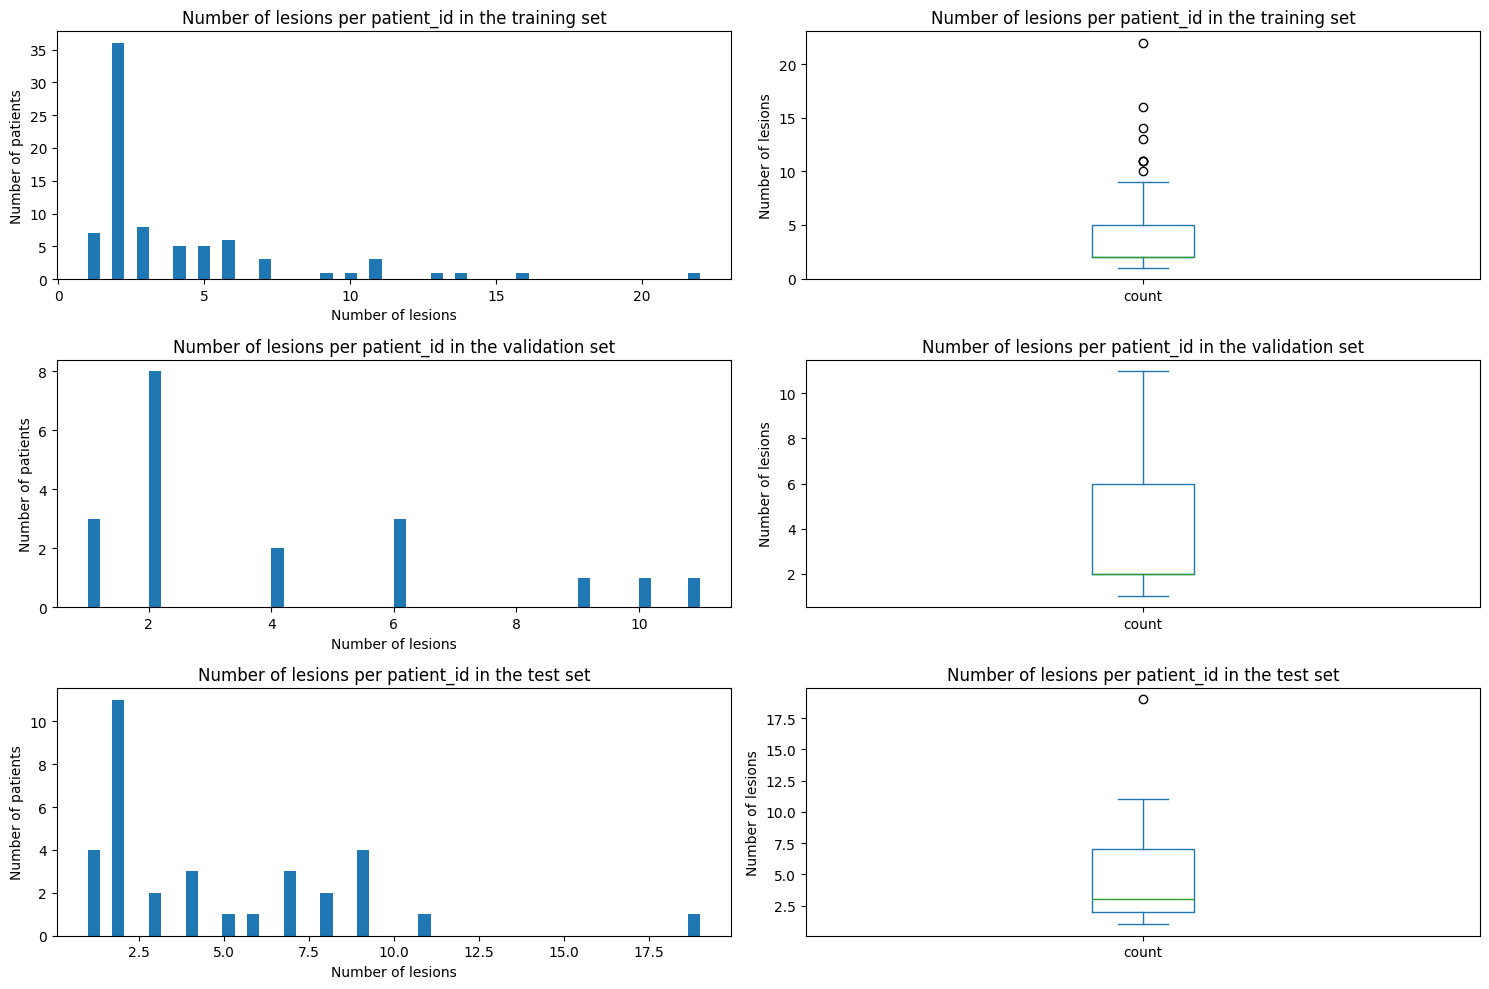

In [36]:
# show statistics of the training, val and test sets
print('Training set:')
print('Number of patients:', train_set['patient_id'].nunique())
print('Number of lesions:', train_set.shape[0])
print('Validation set:')
print('Number of patients:', val_set['patient_id'].nunique())
print('Number of lesions:', val_set.shape[0])
print('Test set:')
print('Number of patients:', test_set['patient_id'].nunique())
print('Number of lesions:', test_set.shape[0])
# plot the number of lesions per patient_id, in form of histogram and boxplot, both for the training and test set together
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
# train
train_set['patient_id'].value_counts().plot(kind='hist', bins=50, ax=axs[0, 0])
axs[0, 0].set_title('Number of lesions per patient_id in the training set')
axs[0, 0].set_xlabel('Number of lesions')
axs[0, 0].set_ylabel('Number of patients')
train_set['patient_id'].value_counts().plot(kind='box', ax=axs[0, 1])
axs[0, 1].set_title('Number of lesions per patient_id in the training set')
axs[0, 1].set_ylabel('Number of lesions')
# val
val_set['patient_id'].value_counts().plot(kind='hist', bins=50, ax=axs[1, 0])
axs[1, 0].set_title('Number of lesions per patient_id in the validation set')
axs[1, 0].set_xlabel('Number of lesions')
axs[1, 0].set_ylabel('Number of patients')
val_set['patient_id'].value_counts().plot(kind='box', ax=axs[1, 1])
axs[1, 1].set_title('Number of lesions per patient_id in the validation set')
axs[1, 1].set_ylabel('Number of lesions')
# test
test_set['patient_id'].value_counts().plot(kind='hist', bins=50, ax=axs[2, 0])
axs[2, 0].set_title('Number of lesions per patient_id in the test set')
axs[2, 0].set_xlabel('Number of lesions')
axs[2, 0].set_ylabel('Number of patients')
test_set['patient_id'].value_counts().plot(kind='box', ax=axs[2, 1])
axs[2, 1].set_title('Number of lesions per patient_id in the test set')
axs[2, 1].set_ylabel('Number of lesions')
fig.tight_layout()
plt.show()

# save the training and test set to csv files
train_set_path = save_meta_dir / 'train_set.csv'
val_set_path = save_meta_dir / 'val_set.csv'
test_set_path = save_meta_dir / 'test_set.csv'
train_set.to_csv(train_set_path, index=False)
val_set.to_csv(val_set_path, index=False)
test_set.to_csv(test_set_path, index=False)
